# Easy read abstracts

This NLP model make to make reading medical papers' abstracts easier.

It's replicate this paper: https://arxiv.org/abs/1710.06071

In [ ]:
# Check to GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-78e58cb3-bdc0-8c37-1ca7-01c93f39452e)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

## Get data

Data taken from authors of paper, that is replicated: https://github.com/Franck-Dernoncourt/pubmed-rct


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.73 MiB/s, done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# Get filenames from directory
import os
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Preprocess data

In [ ]:
# Create a function to read the lines of text to a list
def get_lines(filename):
  """
  Create a function to read the lines of text to a list
  """
  with open(filename, 'r') as f:
      
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
# Preprocess function
import re
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'): # return true/false
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():  # return true/false if line is \n 
      abstract_line_split = abstract_lines.splitlines()

      for line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target, text = abstract_line.split('\t')
        line_data['id'] = re.search('\d+', abstract_id).group(0)
        line_data['target'] = target
        line_data['text'] = text.lower()
        line_data['line_number'] = line_number 
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return  abstract_samples

In [ ]:
%time
train_samples = preprocess_text_with_line_numbers(filename=data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(filename=data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(filename=data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs
180040 30212 30135


In [ ]:
train_samples[:15]

[{'id': '24293578',
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 1,
  'total_lines': 12},
 {'id': '24293578',
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 2,
  'total_lines': 12},
 {'id': '24293578',
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 3,
  'total_lines': 12},
 {'id': '24293578',
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 4,
  'total_lines': 12},
 {'id': 

In [ ]:
import numpy as np
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,id,target,text,line_number,total_lines
0,24293578,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,24293578,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,24293578,METHODS,outcome measures included pain reduction and i...,2,11
3,24293578,METHODS,pain was assessed using the visual analog pain...,3,11
4,24293578,METHODS,secondary outcome measures included the wester...,4,11
5,24293578,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,24293578,RESULTS,there was a clinically relevant reduction in t...,6,11
7,24293578,RESULTS,the mean difference between treatment arms ( @...,7,11
8,24293578,RESULTS,"further , there was a clinically relevant redu...",8,11
9,24293578,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [ ]:
# Distribution of total_lines
train_df.total_lines.value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

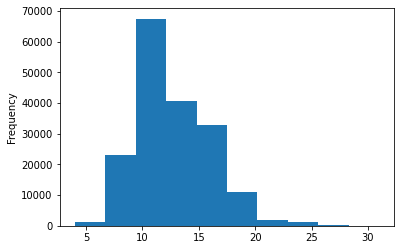

In [ ]:
train_df.total_lines.plot.hist()

### Get lists of sentences

In [ ]:
# Get list of text
train_sent = train_df.text.tolist()
val_sent = val_df.text.tolist()
test_sent = test_df.text.tolist()

### Turn target labels into numbers

#### One Hot Encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False) # we need non-sparse matrix

train_labels_ohe = ohe.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_ohe = ohe.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_ohe = ohe.transform(test_df['target'].to_numpy().reshape(-1, 1))
train_labels_ohe

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_ohe)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

#### Label encode labels

In [ ]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
train_labels_le = label_enc.fit_transform(train_df.target.to_numpy())
val_labels_le = label_enc.transform(val_df.target.to_numpy())
test_labels_le = label_enc.transform(test_df.target.to_numpy())
train_labels_le[:10] 

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_enc.classes_)
class_names = label_enc.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0 Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sent, train_labels_le)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0_pred = model_0.predict(val_sent)
model_0_pred

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": round(model_accuracy, 2),
                  "precision": round(model_precision, 2),
                  "recall": round(model_recall, 2),
                  "f1": round(model_f1, 2)}
  return model_results

In [ ]:
baseline_metrics = calculate_results(y_true=val_labels_le,
                                     y_pred=model_0_pred)
baseline_metrics

{'accuracy': 0.72, 'precision': 0.72, 'recall': 0.72, 'f1': 0.7}

## Turn text into numbers

In [ ]:
# Average amount of words in sentence
sent_tok_len = [len(i.split()) for i in train_sent]
avg_sent_tok_len = np.mean(sent_tok_len)
avg_sent_tok_len

26.338269273494777

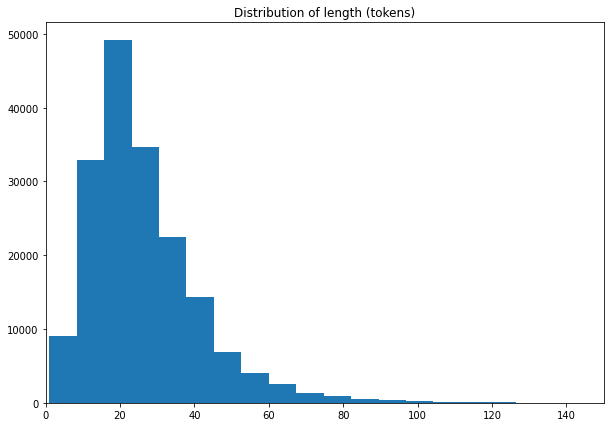

In [ ]:
# Distribution of length
plt.figure(figsize=(10,7))
plt.hist(sent_tok_len, bins=40)
plt.title('Distribution of length (tokens)')
plt.xlim((0,150))
plt.show()

In [ ]:
# How long a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_tok_len, 95))
output_seq_len

55

In [ ]:
# Max length of sentences
max_tok_len = np.max(sent_tok_len)
max_tok_len

296

In [ ]:
# Number of words in vocabulary (takes in a paper)
max_words_vocab = 68000

In [ ]:
# Use TextVectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_words_vocab,
                                    output_sequence_length=output_seq_len,
                                    pad_to_max_tokens=True)
text_vectorizer.adapt(train_sent)

In [ ]:
train_vocab = text_vectorizer.get_vocabulary()

In [ ]:
len(train_vocab)

64841

In [ ]:
train_vocab[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [ ]:
train_vocab[-10650:-10640]

['kilgo',
 'kigali',
 'kieldahl',
 'kidsdott',
 'kidneyyin',
 'kidneyureterbladder',
 'kidneytransplant',
 'kidneypancreas',
 'kidneynourishing',
 'kickoff']

In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_3',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

In [ ]:
# Create Embeding layer
from tensorflow.keras.layers import Embedding
token_embed = Embedding(input_dim=len(train_vocab),
                  output_dim = 128,
                  mask_zero=True)#,
                  #input_length=output_seq_len)

## Creating datasets (increase speed)


In [ ]:
# Turn our data into Tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_sent, train_labels_ohe))
val_ds = tf.data.Dataset.from_tensor_slices((val_sent, val_labels_ohe))
test_ds = tf.data.Dataset.from_tensor_slices((test_sent, test_labels_ohe))

train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Prefetch data
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 CNN with token embeddings

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)


In [ ]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 51, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [ ]:
# Compile model
model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_model_1 = model_1.fit(train_ds,
                              steps_per_epoch=int(0.1*len(train_ds)), 
                              epochs=3,
                              validation_data=val_ds, 
                              validation_steps=int(0.1*len(val_ds)) )

Epoch 1/3
562/562 [==============================] - 40s 60ms/step - loss: 0.9561 - accuracy: 0.6152 - val_loss: 0.7288 - val_accuracy: 0.7151
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6886 - accuracy: 0.7419 - val_loss: 0.6642 - val_accuracy: 0.7603
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6417 - accuracy: 0.7644 - val_loss: 0.6204 - val_accuracy: 0.7746


In [ ]:
# Evaluate on full val_ds
accuracy = model_1.evaluate(val_ds)

945/945 [==============================] - 5s 5ms/step - loss: 0.6165 - accuracy: 0.7808


In [ ]:
# Get predictions
model_1_prob = model_1.predict(val_ds)
model_1_prob

945/945 [==============================] - 3s 3ms/step


array([[4.3061551e-01, 1.8555193e-01, 5.6996491e-02, 3.0840394e-01,
        1.8432017e-02],
       [4.6701264e-01, 2.2677992e-01, 1.3610383e-02, 2.8421992e-01,
        8.3771488e-03],
       [1.7826875e-01, 1.5118907e-02, 3.0973456e-03, 8.0345702e-01,
        5.7902795e-05],
       ...,
       [5.1679253e-06, 9.3674642e-04, 6.3477497e-04, 4.8707006e-06,
        9.9841845e-01],
       [4.2132266e-02, 4.2058310e-01, 1.0179592e-01, 6.5299690e-02,
        3.7018901e-01],
       [2.9269370e-01, 4.8329046e-01, 9.5389172e-02, 7.7047616e-02,
        5.1579107e-02]], dtype=float32)

In [ ]:
model_1_pred = tf.argmax(model_1_prob, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
val_labels_le

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
model_1_metrics = calculate_results(y_true=val_labels_le,
                                     y_pred=model_1_pred)
model_1_metrics

{'accuracy': 0.78, 'precision': 0.78, 'recall': 0.78, 'f1': 0.78}

In [ ]:
baseline_metrics

{'accuracy': 0.72, 'precision': 0.72, 'recall': 0.72, 'f1': 0.7}

## Model 2 Feature extraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub
USE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

use_embed = hub.load(USE_URL)

In [ ]:
use_embed_layer = hub.KerasLayer(USE_URL,
                                 output_shape=(512),
                                 dtype='string')

In [ ]:
# Create a model
from tensorflow.keras import layers
inputs = layers.Input(shape=[], dtype='string')
x = use_embed_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Compile model
model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_model_2 = model_2.fit(train_ds,
                              steps_per_epoch=int(0.1*len(train_ds)), 
                              epochs=3,
                              validation_data=val_ds, 
                              validation_steps=int(0.1*len(val_ds)) )

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9148 - accuracy: 0.6468 - val_loss: 0.7978 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7700 - accuracy: 0.7011 - val_loss: 0.7563 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 15s 27ms/step - loss: 0.7549 - accuracy: 0.7109 - val_loss: 0.7419 - val_accuracy: 0.7141


In [ ]:
# Evaluate on a full val_ds
accuracy_model_2 = model_2.evaluate(val_ds)

945/945 [==============================] - 17s 18ms/step - loss: 0.7407 - accuracy: 0.7144


In [ ]:
# Get predictions
model_2_prob = model_2.predict(val_ds)
model_2_pred = tf.argmax(model_2_prob, axis=1)

945/945 [==============================] - 18s 18ms/step


In [ ]:
# Calculate evaluation metrics
model_2_metrics = calculate_results(y_true=val_labels_le,
                                    y_pred=model_2_pred)
model_2_metrics

{'accuracy': 0.71, 'precision': 0.71, 'recall': 0.71, 'f1': 0.71}

## Character embeddings

### Create a character-level tokeniser

In [ ]:
# Make a function to split sentence into characters
def split_char(text):
  return " ".join(list(text))

In [ ]:
split_char(train_sent[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
list(train_sent[0])

['t',
 'o',
 ' ',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'o',
 'f',
 ' ',
 'd',
 'a',
 'i',
 'l',
 'y',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 ' ',
 'o',
 'r',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 ' ',
 'p',
 'a',
 'i',
 'n',
 ' ',
 ',',
 ' ',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 ' ',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 's',
 'h',
 'o',
 'r',
 't',
 ' ',
 't',
 'e',
 'r',
 'm',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'w',
 'h',
 'e'

In [ ]:
# Split data sets
train_char = [split_char(text) for text in train_sent]
val_char = [split_char(text) for text in val_sent]
test_char = [split_char(text) for text in test_sent]

In [ ]:
# Average amount of characters in sentence
#avg_sent_char_len = sum(len(i) for i in train_sent) / len(train_sent)
sent_char_len = [len(i) for i in train_sent]
avg_sent_char_len = np.mean(sent_char_len)
avg_sent_char_len

149.3662574983337

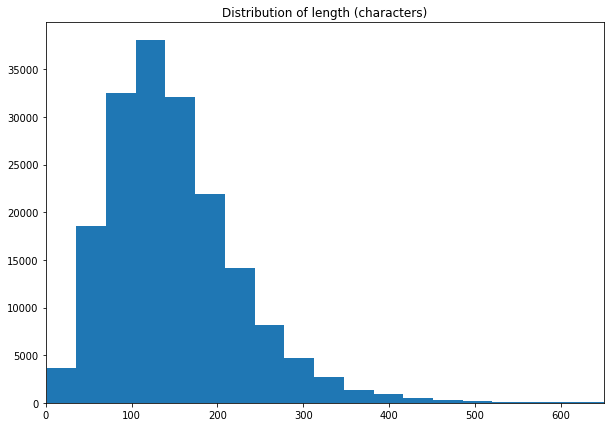

In [ ]:
# Distribution of length (characters)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.hist(sent_char_len, bins=40)
plt.title('Distribution of length (characters)')
plt.xlim((0,650))
plt.show()

In [ ]:
# How long a sentence length covers 95% of examples
output_char_len = int(np.percentile(sent_char_len, 95))
output_char_len

290

In [ ]:
# Get all characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
# Create char-level token vectorizer
num_char = len(alphabet) + 2 # for space and [UNK]
char_vectorizer = TextVectorization(max_tokens=num_char,
                                    output_sequence_length=output_char_len,
                                    #standardize=None, # that's include digits
                                    pad_to_max_tokens=True)

In [ ]:
char_vectorizer.adapt(train_char)

In [ ]:
# Check vocabulary
char_vocab = char_vectorizer.get_vocabulary()
char_vocab, len(char_vocab)

(['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'],
 28)

### Create a character-level embedding layer

In [ ]:
# Create Embeding layer
from tensorflow.keras.layers import Embedding
char_embed = Embedding(input_dim=len(char_vocab),
                       output_dim = 24,
                       mask_zero=True)#,
                  #input_length=output_seq_len)

## Model 3 Conv1D with character embeddings

In [ ]:
# Turn our data into Tensorflow datasets
train_ds_char = tf.data.Dataset.from_tensor_slices((train_char, train_labels_ohe))
val_ds_char = tf.data.Dataset.from_tensor_slices((val_char, val_labels_ohe))
test_ds_char = tf.data.Dataset.from_tensor_slices((test_char, test_labels_ohe))

train_ds_char

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Prefetch data
train_ds_char = train_ds_char.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_char = val_ds_char.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_char = test_ds_char.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds_char

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)


In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
# Compile model
model_3.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_model_3 = model_3.fit(train_ds_char,
                              steps_per_epoch=int(0.1*len(train_ds_char)), 
                              epochs=3,
                              validation_data=val_ds_char, 
                              validation_steps=int(0.1*len(val_ds_char)) )

Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 1.2827 - accuracy: 0.4605 - val_loss: 1.0598 - val_accuracy: 0.5791
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0111 - accuracy: 0.5889 - val_loss: 0.9432 - val_accuracy: 0.6243
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9312 - accuracy: 0.6316 - val_loss: 0.8724 - val_accuracy: 0.6656


In [ ]:
# Evaluate on full val_ds_char
accuracy_model_3 = model_3.evaluate(val_ds_char)

945/945 [==============================] - 5s 5ms/step - loss: 0.9857 - accuracy: 0.6109


In [ ]:
# Get predictions
model_3_prob = model_3.predict(val_ds_char)
model_3_pred = tf.argmax(model_3_prob, axis=1)

945/945 [==============================] - 4s 4ms/step


In [ ]:
# Calculate evaluation metrics
model_3_metrics = calculate_results(y_true=val_labels_le,
                                    y_pred=model_3_pred)
model_3_metrics

{'accuracy': 0.65, 'precision': 0.65, 'recall': 0.65, 'f1': 0.64}

## Model 4 Combining pretrained token embeddings + character embeddings

### Create a combined model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = use_embed_layer(token_inputs)
token_outputs = layers.Dense(296, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char 
token_char_concat = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output])

# 4. Create output layers + dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_reshape = layers.Reshape((1, 344), input_shape=(344,))(combined_dropout)
token_char_bi_lstm = layers.Bidirectional(layers.LSTM(96))(combined_reshape)
final_dropout = layers.Dropout(0.5)(token_char_bi_lstm)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Create a model
model_4 = tf.keras.Model(inputs=[token_inputs, char_inputs],
                         outputs = output_layer)

In [ ]:
model_4.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]']    

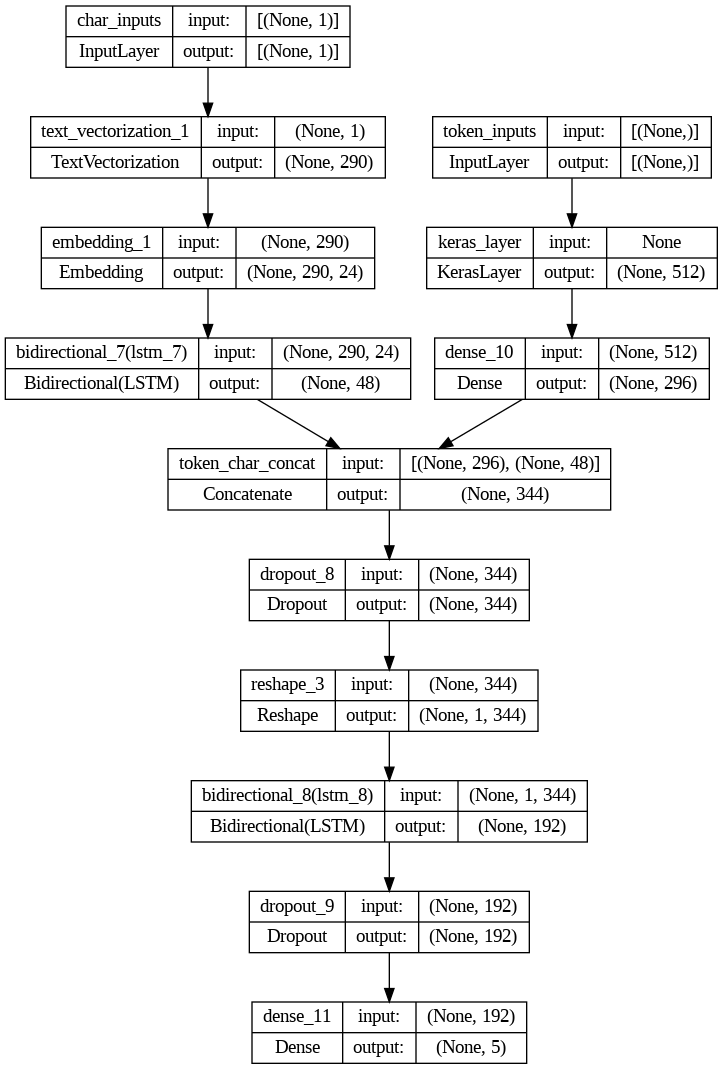

In [ ]:
# Plot the model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile model
model_4.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and character data into tf.data Dataset

In [ ]:
# Create a function to combine token and character datasets
def create_token_char_ds(sentences, chars, labels):
  token_char_data = tf.data.Dataset.from_tensor_slices((sentences, chars))
  token_char_labels = tf.data.Dataset.from_tensor_slices(labels)
  token_char_ds = tf.data.Dataset.zip((token_char_data, token_char_labels))
  return token_char_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create datasets
train_token_char_ds = create_token_char_ds(sentences=train_sent,
                                           chars=train_char, 
                                           labels=train_labels_ohe)
val_token_char_ds = create_token_char_ds(sentences=val_sent,
                                         chars=val_char, 
                                         labels=val_labels_ohe)


### Fiting and evaluating the model

In [ ]:
# Fit the model
history_model_4 = model_4.fit(train_token_char_ds,
                              steps_per_epoch=int(0.1*len(train_token_char_ds)), 
                              epochs=3,
                              validation_data=val_token_char_ds, 
                              validation_steps=int(0.1*len(val_token_char_ds)) )

Epoch 1/3
562/562 [==============================] - 73s 98ms/step - loss: 0.9113 - accuracy: 0.6382 - val_loss: 0.7602 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 50s 89ms/step - loss: 0.7521 - accuracy: 0.7087 - val_loss: 0.6892 - val_accuracy: 0.7377
Epoch 3/3
562/562 [==============================] - 34s 61ms/step - loss: 0.7331 - accuracy: 0.7189 - val_loss: 0.6705 - val_accuracy: 0.7470


In [ ]:
# Make a predictions
model_4_prob = model_4.predict(val_token_char_ds)
model_4_pred = tf.argmax(model_4_prob, axis=1)

945/945 [==============================] - 27s 25ms/step


In [ ]:
model_4_metrics = calculate_results(y_true=val_labels_le,
                                     y_pred=model_4_pred)
model_4_metrics

{'accuracy': 0.74, 'precision': 0.74, 'recall': 0.74, 'f1': 0.74}

## Model 5 Transfer learning with pretrained token

In [ ]:
train_df.head()

,id,target,text,line_number,total_lines
0,24293578,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,24293578,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,24293578,METHODS,outcome measures included pain reduction and i...,2,11
3,24293578,METHODS,pain was assessed using the visual analog pain...,3,11
4,24293578,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [ ]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
line_number_per = int(np.percentile(train_df.line_number, 98))
line_number_per

15

In [ ]:
# Use TensorFlow one hot encoder
train_line_number_ohe = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_number_ohe = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_number_ohe = tf.one_hot(test_df.line_number.to_numpy(), depth=15)
train_line_number_ohe[:20], train_line_number_ohe.shape

(<tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
total_lines_per = int(np.percentile(train_df.total_lines, 98))
total_lines_per

20

In [ ]:
# Use TensorFlow one hot encoder
train_total_lines_ohe = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_lines_ohe = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_ohe = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)
train_total_lines_ohe[:20], train_total_lines_ohe.shape

(<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Create a model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = use_embed_layer(token_inputs)
token_outputs = layers.Dense(296, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. total_line feature
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_line_outputs = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

# 5. Concatenate token and char 
token_char_concat = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)

# 6. Bidirectional layer
combined_reshape = layers.Reshape((1, 344), input_shape=(344,))(combined_dropout)
token_char_bi_lstm = layers.Bidirectional(layers.LSTM(96))(combined_reshape)

# 7. Concatenate line_number feature, total_line feature and token_char_concat 
concat_layer = layers.Concatenate(name='concat_layer')([line_number_model.output, total_line_model.output, token_char_bi_lstm])

# 8. Create output layers + dropout
final_dropout = layers.Dropout(0.5)(concat_layer)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 9. Create a model
model_5 = tf.keras.Model(inputs=[line_number_inputs,
                                 total_line_inputs,
                                 token_inputs, 
                                 char_inputs],
                         outputs = output_layer)

In [ ]:
model_5.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]']    

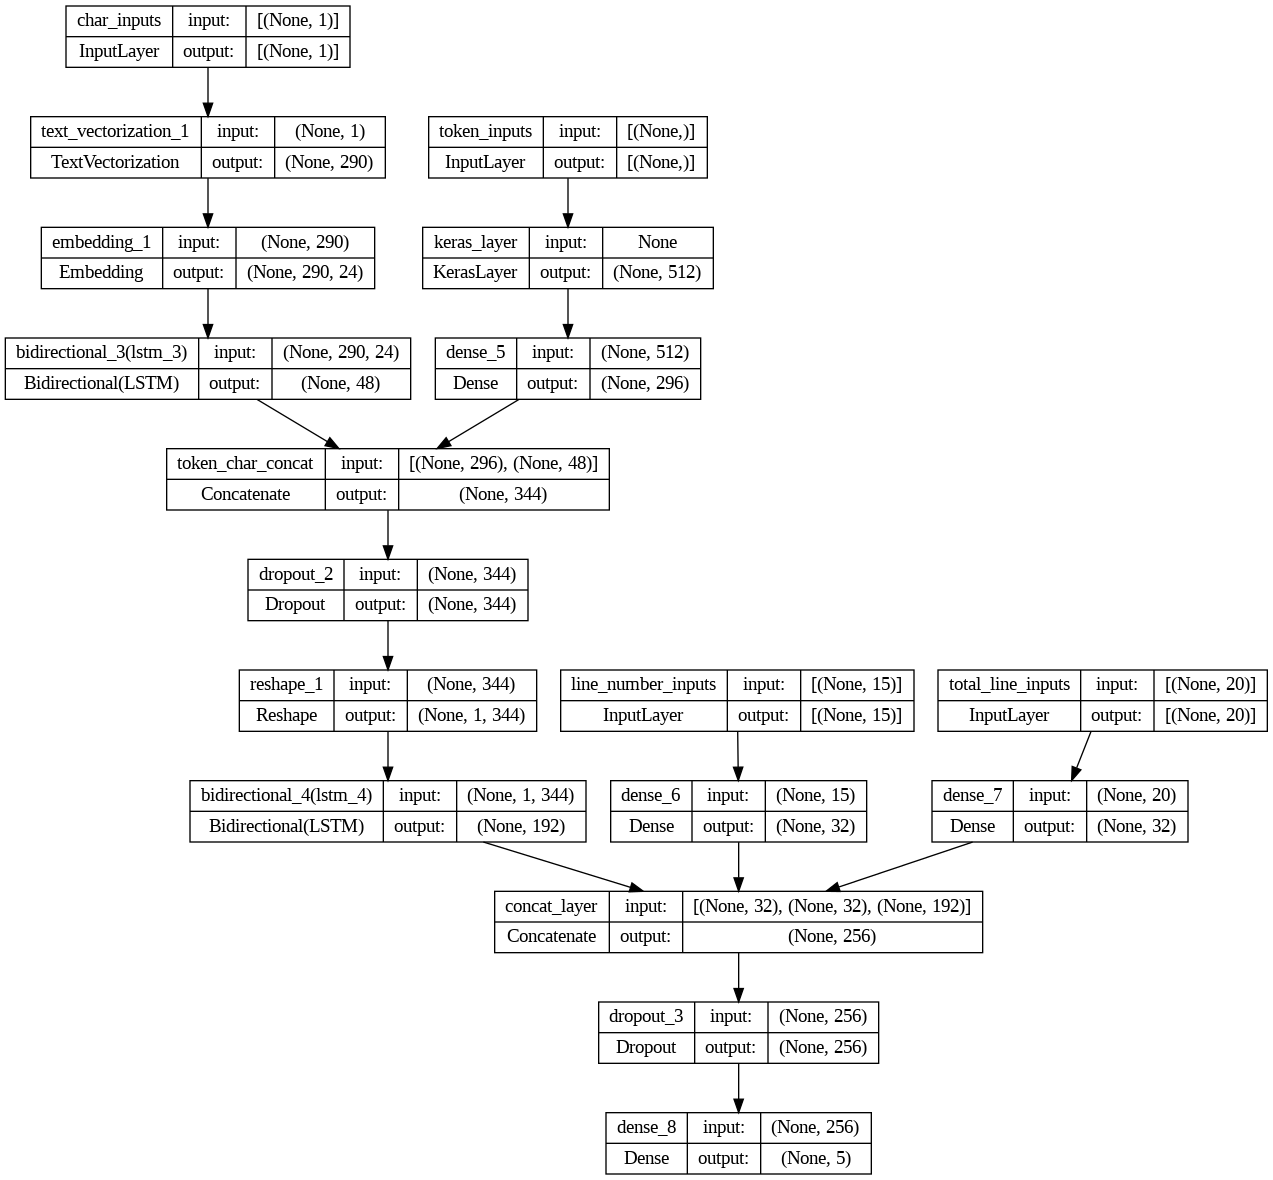

In [ ]:
# Plot the model
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create datasets

In [ ]:
# Create a function to combine token and character datasets
def create_token_char_lines_ds(lines, total_line, sentences, chars, labels):
  token_char_lines_data = tf.data.Dataset.from_tensor_slices((lines, total_line, sentences, chars))
  token_char_lines_labels = tf.data.Dataset.from_tensor_slices(labels)
  token_char_lines_ds = tf.data.Dataset.zip((token_char_lines_data, token_char_lines_labels))
  return token_char_lines_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create datasets
train_token_char_lines_ds = create_token_char_lines_ds(lines=train_line_number_ohe, 
                                                       total_line=train_total_lines_ohe,
                                                       sentences=train_sent,
                                                       chars=train_char, 
                                                       labels=train_labels_ohe)
val_token_char_lines_ds = create_token_char_lines_ds(lines=val_line_number_ohe, 
                                                     total_line=val_total_lines_ohe,
                                                     sentences=val_sent,
                                                     chars=val_char, 
                                                     labels=val_labels_ohe)


In [ ]:
train_token_char_lines_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting and evaluating model_5

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_token_char_lines_ds,
                              steps_per_epoch=int(0.1*len(train_token_char_lines_ds)), 
                              epochs=3,
                              validation_data=val_token_char_lines_ds, 
                              validation_steps=int(0.1*len(val_token_char_lines_ds)) )

Epoch 1/3
562/562 [==============================] - 67s 74ms/step - loss: 1.1440 - accuracy: 0.6898 - val_loss: 1.0078 - val_accuracy: 0.7939
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 1.0119 - accuracy: 0.7844 - val_loss: 0.9660 - val_accuracy: 0.8168
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9913 - accuracy: 0.7982 - val_loss: 0.9522 - val_accuracy: 0.8275


In [ ]:
# Make a predictions
model_5_prob = model_5.predict(val_token_char_lines_ds)
model_5_pred = tf.argmax(model_5_prob, axis=1)

945/945 [==============================] - 24s 22ms/step


In [ ]:
model_5_metrics = calculate_results(y_true=val_labels_le,
                                     y_pred=model_5_pred)
model_5_metrics

{'accuracy': 0.82, 'precision': 0.82, 'recall': 0.82, 'f1': 0.82}

## Compare model results

In [ ]:
compare_results_df = pd.DataFrame({'baseline_model':baseline_metrics,
                                   'cnn_custom_embed_model_1':model_1_metrics,
                                   'feature_extr_model_2':model_2_metrics,
                                   'cnn_char_embed_model_3':model_3_metrics,
                                   'token_char_embed_model_4':model_4_metrics,
                                   'position_token_char_model_5': model_5_metrics})

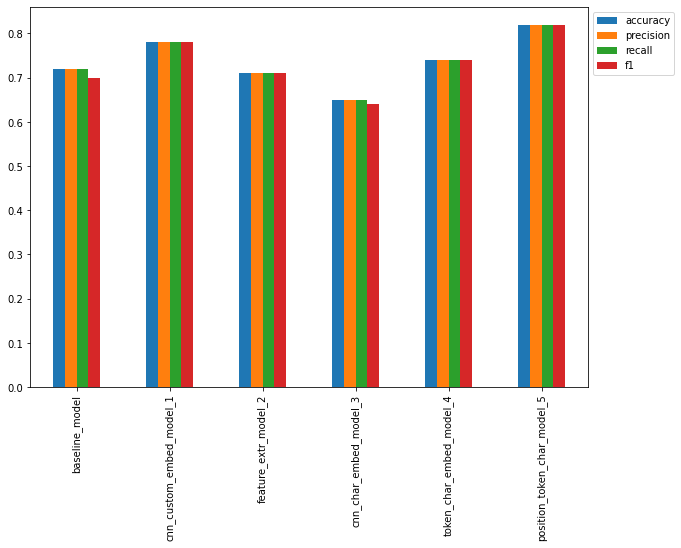

In [ ]:
# Plot bar plots
import matplotlib.pyplot as plt
compare_results_df.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

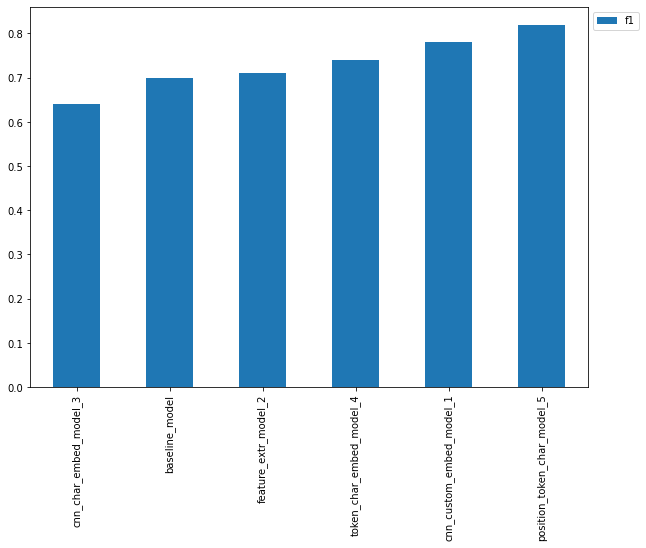

In [ ]:
compare_results_df.f1.sort_values().plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

## Model 5 with all data

In [ ]:
# Create checkpoints
check_path = '/content/drive/MyDrive/nlp_project/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience = 3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-5)

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = use_embed_layer(token_inputs)
token_outputs = layers.Dense(296, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. total_line feature
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_line_outputs = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

# 5. Concatenate token and char 
token_char_concat = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)

# 6. Bidirectional layer
combined_reshape = layers.Reshape((1, 344), input_shape=(344,))(combined_dropout)
token_char_bi_lstm = layers.Bidirectional(layers.LSTM(96))(combined_reshape)

# 7. Concatenate line_number feature, total_line feature and token_char_concat 
concat_layer = layers.Concatenate(name='concat_layer')([line_number_model.output, total_line_model.output, token_char_bi_lstm])

# 8. Create output layers + dropout
final_dropout = layers.Dropout(0.5)(concat_layer)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 9. Create a model
best_model = tf.keras.Model(inputs=[line_number_inputs,
                                 total_line_inputs,
                                 token_inputs, 
                                 char_inputs],
                         outputs = output_layer)
# Compile model
best_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_best_model = best_model.fit(train_token_char_lines_ds,
                              steps_per_epoch=len(train_token_char_lines_ds), 
                              epochs=6,
                              validation_data=val_token_char_lines_ds, 
                              validation_steps=int(0.1 * len(val_token_char_lines_ds)),
                              callbacks=[checkpoint_callback, early_stopping, reduce_lr])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/6
5627/5627 [==============================] - ETA: 0s - loss: 0.9933 - accuracy: 0.7963
Epoch 1: val_loss improved from inf to 0.92342, saving model to /content/drive/MyDrive/nlp_project/checkpoint
5627/5627 [==============================] - 319s 53ms/step - loss: 0.9933 - accuracy: 0.7963 - val_loss: 0.9234 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 2/6
5627/5627 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.8293
Epoch 2: val_loss improved from 0.92342 to 0.90793, saving model to /content/drive/MyDrive/nlp_project/checkpoint
5627/5627 [==============================] - 310s 55ms/step - loss: 0.9437 - accuracy: 0.8293 - val_loss: 0.9079 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 3/6
5627/5627 [==============================] - ETA: 0s - loss: 0.9303 - accuracy: 0.8378
Epoch 3: val_loss improved from 0.90793 to 0.89991, saving model to /content/drive/MyDrive/nlp_project/checkpoint
5627/5627 [==============================] - 315s 56ms/step - loss: 0.930

## Save the best model

In [ ]:
model.save('/content/drive/MyDrive/token_char_lines_best_model_all_data')
loaded_best_model = tf.keras.models.load_model('/content/drive/MyDrive/token_char_lines_best_model_all_data')


In [ ]:
best_model.save('/content/drive/MyDrive/token_char_lines_best_model_all_data')

In [ ]:
loaded_best_model = tf.keras.models.load_model('/content/drive/MyDrive/token_char_lines_best_model_all_data')

In [ ]:
loaded_best_model.evaluate(val_token_char_lines_ds)

945/945 [==============================] - 27s 23ms/step - loss: 0.8909 - accuracy: 0.8505


[0.8909228444099426, 0.8505229949951172]

In [ ]:
# Make a predictions
best_model_prob = loaded_best_model.predict(val_token_char_lines_ds)
best_model_pred = tf.argmax(best_model_prob, axis=1)

In [ ]:
# Calculate evaluation metrics
best_model_metrics = calculate_results(y_true=val_labels_le,
                                       y_pred=best_model_pred)
best_model_metrics

## Check the most wrong predictions

In [ ]:
# Create a DataFrame with results of predictions
results_df = pd.DataFrame({'text':val_sent,
                           'target':val_labels_le,
                           'true_label':[class_names[i] for i in val_labels_le],
                           'prediction':best_model_pred,
                           'pred_label':[class_names[i] for i in best_model_pred],
                           'probability':np.max(best_model_prob, axis=1)})


In [ ]:
# Save the csv file
results_df.to_csv('/content/drive/MyDrive/nlp_project/val_results.csv', index=False)

In [ ]:
import pandas as pd
results_df = pd.read_csv('/content/drive/MyDrive/nlp_project/val_results.csv', index_col=False)

In [ ]:
results_df = results_df.drop(['Unnamed: 0'], axis=1)
results_df.head(7)


,text,target,true_label,prediction,pred_label,probability
0,ige sensitization to aspergillus fumigatus and...,0,BACKGROUND,0,BACKGROUND,0.585905
1,it is not clear whether these patients would b...,0,BACKGROUND,0,BACKGROUND,0.573810
2,we sought to determine whether a @-month cours...,3,OBJECTIVE,3,OBJECTIVE,0.434487
3,asthmatic patients who were ige sensitized to ...,2,METHODS,2,METHODS,0.777525
4,primary outcomes were improvement in quality o...,2,METHODS,2,METHODS,0.755459
5,sixty-five patients were randomized .,4,RESULTS,4,RESULTS,0.794575
6,fifty-nine patients started treatment ( @ rece...,4,RESULTS,4,RESULTS,0.694372


In [ ]:
# Create a DataFrame with wrong predictions
wrong_predictions = results_df.query('target != prediction')
wrong_predictions.head(10)

,text,target,true_label,prediction,pred_label,probability
13,the present pilot study tested the hypothesis ...,3,OBJECTIVE,0,BACKGROUND,0.393350
18,naltrexone and alprazolam each significantly a...,4,RESULTS,1,CONCLUSIONS,0.485935
19,the combination attenuated a greater number of...,4,RESULTS,1,CONCLUSIONS,0.466584
24,we tested the impact of conceptual instruction...,3,OBJECTIVE,2,METHODS,0.315632
25,we also examined the learning processes suppor...,3,OBJECTIVE,0,BACKGROUND,0.374817
26,we worked with @ second - and third-grade chil...,2,METHODS,4,RESULTS,0.535748
28,providing conceptual instruction first resulte...,4,RESULTS,2,METHODS,0.369821
35,in @ clinics within a large academic cancer ce...,2,METHODS,4,RESULTS,0.503319
48,high risk of error was being certain that inco...,2,METHODS,4,RESULTS,0.749784
49,the results are given as the mean ( sd ) .,2,METHODS,4,RESULTS,0.810373


In [ ]:
# Find out which labels are predicted wrong most often
wrong_predictions.target.value_counts()

3    1192
2    1031
4     946
1     808
0     539
Name: target, dtype: int64

Most errors are observed in the predicted of OBJECTIVE and METHODS	

In [ ]:
# Find out the most wrong predictions (with the highest probability)
most_wrong_predictions = wrong_predictions.sort_values(['probability'], ascending=False)
most_wrong_predictions.head(10)

,text,target,true_label,prediction,pred_label,probability
18208,to compare pain response outcomes for patients...,0,BACKGROUND,3,OBJECTIVE,0.905113
21580,to evaluate the potential efficacy and safety ...,0,BACKGROUND,3,OBJECTIVE,0.896874
16173,a qol questionnaire including a pain scale wil...,1,CONCLUSIONS,2,METHODS,0.894856
7300,to examine the effects of complex cognitive ( ...,0,BACKGROUND,3,OBJECTIVE,0.891916
19138,to determine the relationship between type thr...,0,BACKGROUND,3,OBJECTIVE,0.890837
22280,adverse reaction occurrence rate was observed ...,2,METHODS,4,RESULTS,0.884772
11078,only lbm and clcr were found to be determinant...,1,CONCLUSIONS,4,RESULTS,0.881915
2321,the risk of subsequent relapse among those who...,2,METHODS,4,RESULTS,0.878002
8345,there was one patient who developed a non-fata...,1,CONCLUSIONS,4,RESULTS,0.877196
19880,clinic-derived systolic blood pressure obtaine...,4,RESULTS,2,METHODS,0.876068


In [ ]:
# Visualize the most wrong predictions
index = 0
num = 20

for i, row in enumerate(most_wrong_predictions[index:index+num].itertuples()):
  _, text, _, true_label, _, pred_label, prob = row
  print('\n***\n')
  print(f'Sentense: {i+1}\n{text}\n')
  print(f'True label: {true_label}\nPredict: {pred_label}\nProbability: {prob}')
  



***

Sentense: 1
to compare pain response outcomes for patients with spinal bone metastases treated with resistance training of the spinal musculature versus passive physical therapy during radiotherapy ( rt ) .

True label: BACKGROUND
Predict: OBJECTIVE
Probability: 0.90511286

***

Sentense: 2
to evaluate the potential efficacy and safety of inner limiting membrane ( ilm ) staining with brilliant blue g ( bbg ) under air infusion .

True label: BACKGROUND
Predict: OBJECTIVE
Probability: 0.89687365

***

Sentense: 3
a qol questionnaire including a pain scale will assess changes from baseline scores through @ months .

True label: CONCLUSIONS
Predict: METHODS
Probability: 0.8948558

***

Sentense: 4
to examine the effects of complex cognitive ( mahjong ) and physical ( tai chi ) activities on dementia severity in nursing home residents with dementia .

True label: BACKGROUND
Predict: OBJECTIVE
Probability: 0.89191633

***

Sentense: 5
to determine the relationship between type three s

Basically, the model makes a most wrong predictions in choosing between **BACKGROUND** and **OBJECTIVE**(sentense 1, 2, 4, 5), **RESULTS** and **METHODS**(6, 8, 10, 12, 13, 14, 16, 17, 20) between **CONCLUSIONS** and **RESULTS**(7, 9, 15, 18, 19).


As for pair **BACKGROUND** and **OBJECTIVE**, in my opinion, many of  sentences that have target **BACKGROUND** are actually **OBJECTIVE**. They start with words like "to compare", "to evaluate", "to examine" etc., which is typical for denoting a **OBJECTIVE**. The meaning of these sentences shows the objective of research.

Maybe the wrong predictions can be explained by incorrect placement of labels in the validation set. 


---
Most of the errors (9 times) in the first 20 wrong predictions were made when choosing between **RESULTS** and **METHODS**.

The structure of such sentences is likely to be very similar, context is needed to accurately define a label, maybe this is the reason of models wrong predictions. 





---


**CONCLUSIONS** and **RESULTS** are really similar concepts: 
* Conclusion forms the end part of a thesis. 
* Results form the end part of a survey or a chemical experiment

Maybe the reason of wrong predictions is in the many more examples of **RESULTS** sentenses in training set.


## Test model on custom RCT abstracts

In [ ]:
# Read a txt file
text = get_lines('/content/drive/MyDrive/nlp_project/test_abstracts.txt')
text = ' '.join(text)
abstracts = text.split('###')

In [ ]:
# Create a function to preprocess abstracts
def preprocess_abstract(abstract):

  # Replace digits by @
  remove_digits = str.maketrans('0123456789', '@@@@@@@@@@')
  abstract = abstract.translate(remove_digits)
  abstract = abstract.replace('\n', '')
  
  # Split abctract into sentences
  sentences = abstract.split(".")
  abstract_samples = []
  for num, sent in enumerate(sentences):
    line_data = {}
    line_data['line_num'] = num
    line_data['total_lines'] = len(sentences)
    line_data['text'] = sent.lower()
    abstract_samples.append(line_data)

  return abstract_samples


In [ ]:
# Choose the abstract and preprocess it
chosen_abstr = abstracts[3]
abstract = pd.DataFrame(preprocess_abstract(chosen_abstr))
text_sent = abstract.text.to_numpy()
# 
test_line_number_ohe = tf.one_hot(abstract.line_num.to_numpy(), depth=15)
test_total_lines_ohe = tf.one_hot(abstract.total_lines.to_numpy(), depth=20)
test_sent = abstract.text.tolist()
test_char = [split_char(text) for text in test_sent]

# Get predictions
custom_prob = loaded_best_model.predict(x=(test_line_number_ohe,
                                           test_total_lines_ohe,
                                           tf.constant(test_sent),
                                           tf.constant(test_char)))
custom_pred = tf.argmax(custom_prob, axis=1)


# Visualize models' predictions
for i, pred in enumerate(custom_pred):
  label = class_names[pred]
  sent = text_sent[i]
  print(f'{label.upper()} :\n {sent}\n')

1/1 [==============================] - 0s 191ms/step
BACKGROUND :
  placebo injections actually improve lateral epicondylitis at high rates

BACKGROUND :
  no other injections convincingly improve it better than placebo

METHODS :
 corticosteroid injection is not superior to saline or anesthetic injection (strength of recommendation [sor] a, systematic review of randomized controlled trials [rcts])

BACKGROUND :
  platelet-rich plasma (prp) injection is not superior to saline injection (sor a, meta-analysis of rcts)

CONCLUSIONS :
 botulinum toxin injection, compared to saline injection, modestly improved pain in lateral epicondylitis, but with short-term grip-strength weakness (sor a, meta-analysis of rcts)

CONCLUSIONS :
  prolotherapy injection, compared to saline injection, improved pain at @@-week, but not at @-week, follow-up (sor b, one small pilot rct)

CONCLUSIONS :
 hyaluronic acid injection, compared to saline injection, resulted in a statistically significant pain reduction

## Conclusion

The model replicated the paper https://arxiv.org/abs/1710.06071, consists of token embeddings (USE model used), character embeddings (custom embeddings) and position embeddings showed an accuracy of **85%**.

The most wrong predictions were in choosen between BACKGROUND/OBJECTIVE, RESULTS/METHODS and CONCLUSIONS/RESULTS. 

Some errors are due to unbalanced data, some due to similar sentence structure, and some not quite correct target label in validation set.

But in general, the model predicts labels well, the abstract with the labels becomes much more convenient to read. This gives a better represent of the content of the article.